## Imports

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

RANDSTATE=42
np.random.seed(RANDSTATE)

## MNIST

In [2]:
from sklearn.datasets import fetch_openml
# get mnist data
mnist = fetch_openml("mnist_784",version=1, as_frame=False)
X_data,y_data = mnist['data'], mnist['target']
y_data = y_data.astype(np.uint8)
# split data
X_train, X_test, y_train, y_test = X_data[:60000], X_data[60000:], y_data[:60000], y_data[60000:]

## Classifiers

## sgd

In [3]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.model_selection import cross_val_score
# # sgd_clf = SGDClassifier(max_iter=100, tol=1e-3, random_state=RANDSTATE)
# # sgd_clf.fit(X_train, y_train)

## knn

In [4]:
# knn
from sklearn.neighbors import KNeighborsClassifier  
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
idx=99
pred = knn_clf.predict([X_test[idx]])

In [5]:
# knn metric f1 score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

y_pred_knn = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_knn = f1_score(y_train, y_pred_knn,average="macro")
print("f1_knn",f1_knn)

f1_knn 0.9672164755274896


## knn GridSearch

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "weights":["uniform","distance"],
    "n_neighbors":[1,3,5,7,9]
}
grid_search = GridSearchCV(knn_clf,param_grid,cv=3,verbose=1)
# grid_search.fit(X_train,y_train)
# grid_search.best_estimator_

In [7]:
param_grid = {
    "weights":["uniform","distance"],
    "n_neighbors":[2,3,4]
}
grid_search2 = GridSearchCV(knn_clf,param_grid,cv=3,verbose=1)
grid_search2.fit(X_train,y_train)
grid_search2.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [10]:
try:
    if grid_search.best_score_ > grid_search2.best_score_:
        best_model = grid_search.best_estimator_
    else:
        best_model = grid_search2.best_estimator_
except AttributeError:
    best_model = grid_search2.best_estimator_

In [11]:
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import f1_score

base = cross_val_score(knn_clf,
    X_train, y_train, cv=3, scoring="accuracy").mean()
best = cross_val_score(best_model,
    X_train, y_train, cv=3, scoring="accuracy").mean()
print(base,best)

# f1_best = f1_score(y_train, y_pred_best,average="macro")
# print("f1_best",f1_best)
# print("f1_knn",f1_knn)

0.9674166666666667 0.9703500000000002


# Training set expansion

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def shift_img(data:np.ndarray,shift,axis)->np.ndarray:
    """
    axis: int, 0 or 1
    shift: int, default=1
    https://m.blog.naver.com/wideeyed/221665256911
    https://numpy.org/doc/stable/reference/generated/numpy.roll.html
    https://stackoverflow.com/questions/12575421/convert-a-1d-array-to-a-2d-array-in-numpy
    """
    # padding=shift+1
    padding=5
    mat = np.reshape(data,(28,28))
    padded = np.pad(mat, ((padding,padding),(padding,padding)), 'constant', constant_values=100)
    shifted = np.roll(padded, shift=shift,axis=axis)
    return padded[padding:-padding,padding:-padding].flatten()


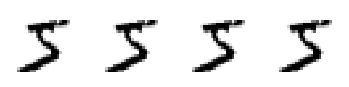

In [13]:
sample = X_data[0]

plt.subplot(141)
img_shifted = shift_img(sample,shift=5,axis=1)
plot_digit(img_shifted)

plt.subplot(142)
img_shifted = shift_img(sample,shift=-5,axis=1)
plot_digit(img_shifted)

plt.subplot(143)
img_shifted = shift_img(sample,shift=-5,axis=0)
# print(img_shifted.shape)
plot_digit(img_shifted)

plt.subplot(144)
img_shifted = shift_img(sample,shift=5,axis=0)
plot_digit(img_shifted)

In [14]:
print(type(X_train),X_train.shape) # (60000, 784)

X_train_expand = []
y_train_expand = []
# for idx,data in enumerate(X_train[:10]):
for idx,data in enumerate(X_train):
    for shift,axis in [(1,1),(-1,1),(1,0),(-1,0)]:
        new_data = shift_img(data,shift,axis)
        X_train_expand.append(new_data)
        y_train_expand.append(y_train[idx])

<class 'numpy.ndarray'> (60000, 784)


In [15]:
# # plotting
# # X_train_new = np.ndarray(X_train_new)
# print(type(X_train_new),len(X_train_new)) # (4*60000, 784)
# # nrows,ncols = len(X_train_new)//1,len(X_train_new)//2
# nrows,ncols = 4,10
# print(y_train_new[:40])
# for index,x in enumerate(X_train_new[:40],1):
#     plt.subplot(nrows,ncols,index)
#     plot_digit(x)

In [16]:
expand = cross_val_score(best_model,
    X_train_expand, y_train_expand, cv=3, scoring="accuracy").mean()
print(base,best,expand)

0.9674166666666667 0.9703500000000002 0.96755
